In [ ]:
# ============================================================
# TP2 – Taller de Programación (UBA)
# Autores: Feijoo – Dolimpio – Rudi  |  Año: 2025
# ============================================================


In [ ]:
#Feijoo
# librerias con las que se va a trabajar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df_t1_05 = pd.read_csv('C:/Users/ASUS Vivobook/Documents/GitHub/BigDataUBA-Grupo5/TP2/df_merged05.csv')
df_t1_25 = pd.read_csv('C:/Users/ASUS Vivobook/Documents/GitHub/BigDataUBA-Grupo5/TP2/df_merged25.csv')

In [ ]:
df_t1_25.columns.tolist()

In [ ]:
df_t1_05.columns.tolist()

In [ ]:
# --- Homologación de nombres ---
# Queremos que ambos dataframes tengan los mismos nombres en MAYÚSCULA
df_t1_25.columns = df_t1_25.columns.str.upper()
df_t1_05.columns = df_t1_05.columns.str.upper()

In [ ]:
print("Tipos de variables en df_t1_05:")
print(df_t1_05.dtypes)
print("\nTipos de variables en df_t1_25:")
print(df_t1_25.dtypes)

In [ ]:
df_t1_05.head()

In [ ]:
df_t1_25.head()

In [ ]:
path_ae = r"C:\Users\ASUS Vivobook\Documents\GitHub\BigDataUBA-Grupo5\TP2\tabla_adulto_equiv.xlsx"
ae_raw = pd.read_excel(path_ae)
ae_raw.columns.tolist()
# Imprimir para verificar
print("Tabla de Factores (df_factores):\n", ae_raw.head())

df_factores_long = ae_raw.melt(
    id_vars=['Edad'],
    value_vars=['Mujeres', 'Varones'],
    var_name='Genero_Factor',
    value_name='Factor_Ajuste'
)

# Renombrar la columna de edad para la unión
df_factores_long = df_factores_long.rename(columns={'Edad': 'Edad_Factor'})
mapeo_genero = {'Varones': 1, 'Mujeres': 2}
df_factores_long['Genero_Codificado'] = df_factores_long['Genero_Factor'].map(mapeo_genero)

print("\nTabla de Factores (Formato Largo):\n", df_factores_long.head(10))

In [ ]:
# 3. Función para clasificar la edad en rangos 
def clasificar_edad(edad):
    if edad < 1:
        return 'Menor de 1 año'
    elif edad == 1:
        return '1 año'
    elif edad == 2:
        return '2 años'
    # ... continúa con el resto de las edades simples ...
    elif edad >= 18 and edad <= 29:
        return '18 a 29 años'
    elif edad >= 30 and edad <= 45:
        return '30 a 45 años'
    elif edad >= 46 and edad <= 60:
        return '46 a 60 años'
    elif edad >= 61 and edad <= 75:
        return '61 a 75 años'
    elif edad > 75:
        return 'más de 75 años'
    else:
        # Esto captura las edades entre 3 y 17 que no son rangos
        return f'{edad} años'

# Aplicar la clasificación a tu base de datos
df_t1_25['edad_rango'] = df_t1_25['CH06'].apply(clasificar_edad)
df_t1_05['edad_rango'] = df_t1_05['CH06'].apply(clasificar_edad)

print("\nBase de Datos con Rango de Edad (df_base):\n", df_t1_25)
print("\nBase de Datos con Rango de Edad (df_base):\n", df_t1_05)

In [ ]:
df_t1_25 = pd.merge(
    df_t1_25,
    df_factores_long,
    left_on=['edad_rango', 'CH04'],
    right_on=['Edad_Factor', 'Genero_Codificado'],
    how='left'  # Usa 'left' para mantener todas las filas de tu base de datos
)

df_t1_05 = pd.merge(
    df_t1_05,
    df_factores_long,
    left_on=['edad_rango', 'CH04'],
    right_on=['Edad_Factor', 'Genero_Codificado'],
    how='left'  # Usa 'left' para mantener todas las filas de tu base de datos
)

print("\nResultado Final (Base Unida):\n", df_t1_25_ad)
print("\nResultado Final (Base Unida):\n", df_t1_05_ad)

In [ ]:
# PARTE 1
# 1) 
# Definir CBT por año (valores de referencia)
cbt = {2005: 205.07, 2025: 365177}

df_sumas05 = df_t1_05.groupby('ID_HOGAR')['Factor_Ajuste'].sum().reset_index()
df_t1_05 = pd.merge(
    df_t1_05,
    df_sumas05,
    on='ID_HOGAR',
    how='left'
)
df_sumas25 = df_t1_25.groupby('ID_HOGAR')['Factor_Ajuste'].sum().reset_index()
df_t1_25 = pd.merge(
    df_t1_25,
    df_sumas25,
    on='ID_HOGAR',
    how='left'  
)

# Crear columna de ingreso necesario
df_t1_05["ITF"] = df_t1_05["IX_TOT"] * df_t1_05["IPCF"]
df_t1_25["ITF"] = df_t1_25["IX_TOT"] * df_t1_25["IPCF"]

df_t1_05["ingreso_necesario"] = df_t1_05["ANO4"].map(cbt) * df_t1_05["Factor_Ajuste_y"]
df_t1_25["ingreso_necesario"] = df_t1_25["ANO4"].map(cbt) * df_t1_25["Factor_Ajuste_y"]

# Crear columna pobre
df_t1_05["pobre"] = np.where(
    df_t1_05["ITF"] < df_t1_05["ingreso_necesario"], 1, 0
)
df_t1_25["pobre"] = np.where(
    df_t1_25["ITF"] < df_t1_25["ingreso_necesario"], 1, 0
)
# Resumen de pobreza
res_pobreza05 = (
    df_t1_05.groupby("ANO4")
    .agg(Total=("pobre", "count"), Pobres=("pobre", "sum"))
    .assign(Pct_Pobres=lambda d: 100 * d["Pobres"] / d["Total"])
)
res_pobreza25 = (
    df_t1_25.groupby("ANO4")
    .agg(Total=("pobre", "count"), Pobres=("pobre", "sum"))
    .assign(Pct_Pobres=lambda d: 100 * d["Pobres"] / d["Total"])
)
print(res_pobreza05)
print(res_pobreza25)

display(df_t1_05.loc[:, ["CODUSU","ANO4","ITF", "IPCF","Factor_Ajuste_y","ingreso_necesario","pobre"]].head(10))

In [ ]:
vars_interes = ['ANO4', 'CH06', 'pobre']

df_05_25 = pd.concat([
    df_t1_05[vars_interes],
    df_t1_25[vars_interes]
], ignore_index=True)

In [ ]:
df_05_25['edad2'] = df_05_25['CH06'] ** 2

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Panel A: Histograma de edad
sns.histplot(df_05_25['CH06'], bins=20, kde=False, color='skyblue', ax=axes[0])
axes[0].set_title('Panel A: Histograma de la edad')
axes[0].set_xlabel('Edad')
axes[0].set_ylabel('Frecuencia')

# Panel B: Densidad (kernel) por condición de pobreza
sns.kdeplot(data=df_05_25, x='CH06', hue='pobre', ax=axes[1], fill=False)
axes[1].set_title('Panel B: Distribución de edad según pobreza')
axes[1].set_xlabel('Edad')
axes[1].set_ylabel('Densidad')
axes[1].legend(title='Pobreza', labels=['No pobre', 'Pobre'])

plt.tight_layout()
plt.show()

In [1]:
#Rudi
# --- Instalación (si hace falta) ---
# !pip install pandas pyreadstat openpyxl

# --- Librerías ---
import pandas as pd

# --- Rutas (ajustá si cambiaron) ---
path_ind_2005 = r"C:\Users\gasto\Desktop\Taller de Programación\TP1\Individual_t105.dta"
path_ind_2025 = r"C:\Users\gasto\Desktop\Taller de Programación\TP1\usu_individual_T125.xlsx"

# --- Carga de datos ---
df_t1_05 = pd.read_stata(ruta_2005, convert_categoricals=False)
df_t1_25 = pd.read_excel(ruta_2025)

# --- Homologación de nombres ---
# Queremos que ambos dataframes tengan los mismos nombres en MAYÚSCULA
variables_std = [
    'CODUSU','NRO_HOGAR','ANO4', 'CH03','CH04','CH06','CH07','CH08','CH12','CH13','CH14',
    'ITF','PP3E_TOT','PP3F_TOT','NIVEL_ED','ESTADO','CAT_INAC','IPCF','PP04A','PONDERA'
]

# Mapeo 2005 (minúsculas) -> estándar (MAYÚSCULA)
map_05_to_std = {
    'codusu':'CODUSU','nro_hogar':'NRO_HOGAR','ano4':'ANO4', 'ch03':'CH03','ch04':'CH04','ch06':'CH06',
    'ch07':'CH07','ch08':'CH08','ch12':'CH12','ch13':'CH13','ch14':'CH14',
    'itf':'ITF','pp3e_tot':'PP3E_TOT','pp3f_tot':'PP3F_TOT','nivel_ed':'NIVEL_ED',
    'estado':'ESTADO','cat_inac':'CAT_INAC','ipcf':'IPCF','pp04a':'PP04A','pondera':'PONDERA',
    'region':'REGION'
}

# Renombrar 2005
df_t1_05_ren = df_t1_05.rename(columns={c: map_05_to_std.get(c.lower(), c) for c in df_t1_05.columns})

# Asegurar que 2025 esté en MAYÚSCULA (por si viene mezclado)
df_t1_25_ren = df_t1_25.rename(columns={c: c.upper() for c in df_t1_25.columns})

# --- Filtro por región Patagonia (44) ---
# En 2025 la columna es REGION; en 2005 la acabamos de crear al renombrar
if 'REGION' in df_t1_25_ren.columns:
    df_t1_25_pat = df_t1_25_ren[df_t1_25_ren['REGION'] == 44].copy()
else:
    raise KeyError("La base 2025 no tiene la columna 'REGION'.")

if 'REGION' in df_t1_05_ren.columns:
    df_t1_05_pat = df_t1_05_ren[df_t1_05_ren['REGION'] == 44].copy()
else:
    raise KeyError("La base 2005 no tiene la columna 'region/REGION'.")

# --- Selección de variables comunes ---
cols_25 = [c for c in variables_std if c in df_t1_25_pat.columns]
cols_05 = [c for c in variables_std if c in df_t1_05_pat.columns]

df_t1_25_pat = df_t1_25_pat[cols_25]
df_t1_05_pat = df_t1_05_pat[cols_05]

# --- Vista rápida (cabeza) ---
print("Base 2005 (Patagonia) - columnas:", df_t1_05_pat.columns.tolist())
display(df_t1_05_pat.head(10))

print("\nBase 2025 (Patagonia) - columnas:", df_t1_25_pat.columns.tolist())
display(df_t1_25_pat.head(10))

NameError: name 'ruta_2005' is not defined

In [ ]:
# --- Análisis detallado de PP3F_TOT ---

for año, df in {'2005': df_t1_05_pat, '2025': df_t1_25_pat}.items():
    print(f'\n=== {año} - Variable PP3F_TOT ===')
    if 'PP3F_TOT' not in df.columns:
        print("⚠️ No existe la columna en esta base.")
        continue

    # Conteos de valores nulos y ceros
    total = len(df)
    nulos = df['PP3F_TOT'].isna().sum()
    ceros = (df['PP3F_TOT'] == 0).sum()
    print(f"Total registros: {total:,}")
    print(f"Nulos: {nulos:,}  ({nulos/total:.1%})")
    print(f"Ceros: {ceros:,}  ({ceros/total:.1%})")

    # Si hay valores no nulos distintos de cero, mostrar estadísticas
    df_validos = df.loc[df['PP3F_TOT'].notna() & (df['PP3F_TOT'] != 0), 'PP3F_TOT']
    if len(df_validos) > 0:
        print("\nEstadísticas de los valores no nulos/no ceros:")
        display(df_validos.describe())
    else:
        print("❌ Todos los valores son 0 o NaN.")

In [ ]:
import numpy as np
import pandas as pd

def limpiar_horas_segunda_ocupacion(df, col='PP3F_TOT'):
    s = pd.to_numeric(df[col], errors='coerce')
    # Opcional: registrar casos especiales para auditoría
    reporte = {
        'total': len(s),
        'na_iniciales': int(s.isna().sum()),
        'ceros': int((s == 0).sum()),
        'negativos': int((s < 0).sum()),
        'mayores_100': int((s > 100).sum()),
        'sentinelas_999': int((s == 999).sum()),
        'decimales': int(((s % 1) != 0).sum())
    }
    # Reglas de limpieza
    s_clean = s.copy()
    # Marcar sentinelas conocidos como NaN
    s_clean = s_clean.mask(s_clean.isin([98, 99, 999]))
    # Invalidar negativos, >100 y decimales
    s_clean = s_clean.mask((s_clean < 0) | (s_clean > 100) | ((s_clean % 1) != 0))
    # Dejar como Int64 (permite NaN)
    s_clean = s_clean.astype('Int64')
    return s_clean, reporte

# Aplicar a ambas bases
df_t1_05_pat['PP3F_TOT_LIMPIO'], rep05 = limpiar_horas_segunda_ocupacion(df_t1_05_pat, 'PP3F_TOT')
df_t1_25_pat['PP3F_TOT_LIMPIO'], rep25 = limpiar_horas_segunda_ocupacion(df_t1_25_pat, 'PP3F_TOT')

print('Reporte 2005:', rep05)
print('Reporte 2025:', rep25)

# Chequeo rápido post-limpieza
for año, df in {'2005': df_t1_05_pat, '2025': df_t1_25_pat}.items():
    s = df['PP3F_TOT_LIMPIO']
    print(f'\n=== {año} - PP3F_TOT_LIMPIO ===')
    print('Distribución (top 15):')
    print(s.value_counts(dropna=False).head(15))
    print('\nResumen horas válidas (1–100):')
    display(s.dropna().loc[s.dropna() > 0].describe())

In [ ]:
import pandas as pd
import numpy as np

# -------- 1) Esquema estándar --------
COLS_STD = ['CODUSU','NRO_HOGAR','ANO4','CH04','CH06','CH07','CH08','CH12','CH13','CH14',
            'ITF','PP3E_TOT','PP3F_TOT','NIVEL_ED','ESTADO','CAT_INAC','IPCF','PP04A','PONDERA']

DTYPES_STR   = ['CODUSU']
DTYPES_INT64 = ['NRO_HOGAR','ANO4','CH04','CH06','CH07','CH08','CH12','CH13','CH14',
                'NIVEL_ED','ESTADO','CAT_INAC','PP04A','PONDERA']
DTYPES_F64   = ['ITF','PP3E_TOT','PP3F_TOT','IPCF']

def limpiar_horas_segunda_ocupacion(s: pd.Series) -> pd.Series:
    s = pd.to_numeric(s, errors='coerce')
    # sentinelas + reglas
    s = s.mask(s.isin([98, 99, 999]))
    s = s.mask((s < 0) | (s > 100) | ((s % 1) != 0))
    return s.astype('Int64')

def armonizar(df: pd.DataFrame, periodo: str, trimestre: int = 1) -> pd.DataFrame:
    df = df.copy()
    # Asegurar columnas esperadas si faltan (las crea como NaN)
    for c in COLS_STD:
        if c not in df.columns:
            df[c] = pd.NA
    # Tipos
    for c in DTYPES_STR:
        df[c] = df[c].astype('string')
    for c in DTYPES_INT64:
        df[c] = pd.to_numeric(df[c], errors='coerce').astype('Int64')
    for c in DTYPES_F64:
        df[c] = pd.to_numeric(df[c], errors='coerce').astype('Float64')

    # Limpieza PP3F_TOT (horas 2da ocupación)
    df['PP3F_TOT_LIMPIO'] = limpiar_horas_segunda_ocupacion(df['PP3F_TOT'])

    # Orden final de columnas
    orden = COLS_STD + ['PP3F_TOT_LIMPIO']
    df = df[orden]

    # Metadatos de periodo
    df['TRIMESTRE'] = pd.Series([trimestre]*len(df), dtype='Int64')
    df['PERIODO']   = periodo  # string útil para filtros/plots (p. ej. "T1-2005")

    return df

# -------- 2) Aplicar a cada base --------
# Asumo que ya tenés df_t1_05_pat y df_t1_25_pat del paso anterior
df05_std = armonizar(df_t1_05_pat, periodo="T1-2005", trimestre=1)
df25_std = armonizar(df_t1_25_pat, periodo="T1-2025", trimestre=1)

# Chequeo rápido
print("2005 tipos:\n", df05_std.dtypes.head(12))
print("\n2025 tipos:\n", df25_std.dtypes.head(12))

# -------- 3) Unificar en una sola tabla --------
df_panel = pd.concat([df05_std, df25_std], ignore_index=True)

print("\nDataset unificado:")
print(df_panel.shape)
display(df_panel.head(10))
display(df_panel.tail(10))

In [ ]:
import pandas as pd
import numpy as np

# Partimos de df_panel
df_panel_limpio = df_panel.copy()

# Asegurar tipos numéricos (manteniendo NaN cuando haga falta)
df_panel_limpio['CH06'] = pd.to_numeric(df_panel_limpio['CH06'], errors='coerce')  # edad
df_panel_limpio['IPCF'] = pd.to_numeric(df_panel_limpio['IPCF'], errors='coerce')  # ingreso per cápita fam.

antes = df_panel_limpio.shape[0]

# Más estable que query(): filtrar con máscaras booleanas
mask_valid = (
    (df_panel_limpio['CH06'].isna() | (df_panel_limpio['CH06'] >= 0)) &
    (df_panel_limpio['IPCF'].isna() | (df_panel_limpio['IPCF'] >= 0))
)
df_panel_limpio = df_panel_limpio.loc[mask_valid].copy()

despues = df_panel_limpio.shape[0]
print(f"Filas antes: {antes:,}  |  después: {despues:,}  |  eliminadas: {antes - despues:,}")

# Chequeos
print("Edad mínima:", df_panel_limpio['CH06'].min())
print("Ingreso mínimo:", df_panel_limpio['IPCF'].min())

# (Opcional) si querés además descartar edades no lógicas (p. ej. > 110), descomentá:
# df_panel_limpio = df_panel_limpio.loc[df_panel_limpio['CH06'].isna() | (df_panel_limpio['CH06'] <= 110)]

# Guardar a Excel y CSV
out_xlsx = "panel_patagonia_T1_2005_2025_limpio.xlsx"
out_csv  = "panel_patagonia_T1_2005_2025_limpio.csv"

with pd.ExcelWriter(out_xlsx, engine="openpyxl") as writer:
    df_panel_limpio.to_excel(writer, sheet_name="panel_limpio", index=False)

df_panel_limpio.to_csv(out_csv, index=False)

print("✅ Archivos guardados:")
print(" -", out_xlsx)
print(" -", out_csv)

In [ ]:
import pandas as pd
import numpy as np

# Base de trabajo
base = (df_panel_limpio if 'df_panel_limpio' in globals() else df_panel).copy()

# Asegurar numéricos
for c in ['CH12','CH13','CH14','ANO4','ANIO','PONDERA']:
    if c in base.columns:
        base[c] = pd.to_numeric(base[c], errors='coerce')

# Año
base['ANIO'] = pd.to_numeric(base.get('ANIO', base.get('ANO4')), errors='coerce').astype('Int64')

# Limpiar CH13 (9 = Ns/Nr -> NaN)
base['CH13'] = base['CH13'].replace({9: np.nan})

# Limpiar CH14 (00-09) y sentinelas
base['CH14'] = base['CH14'].replace({98: np.nan, 99: np.nan, 999: np.nan})
base['CH14'] = pd.to_numeric(base['CH14'], errors='coerce').fillna(np.nan)

# Parametrización por nivel (CH12)
level_params = {
    1: {'base': 0,  'maxyrs': 0},   # Jardín/Preescolar
    2: {'base': 0,  'maxyrs': 6},   # Primario
    3: {'base': 0,  'maxyrs': 9},   # EGB
    4: {'base': 6,  'maxyrs': 6},   # Secundario
    5: {'base': 9,  'maxyrs': 3},   # Polimodal
    6: {'base': 12, 'maxyrs': 3},   # Terciario no universitario
    7: {'base': 12, 'maxyrs': 5},   # Universitario
    8: {'base': 17, 'maxyrs': 3},   # Posgrado
    9: {'base': np.nan, 'maxyrs': np.nan},  # Educación especial (no comparable)
}

def construir_educ(df):
    educ = pd.Series(np.nan, index=df.index, dtype='Float64')
    for lvl, prm in level_params.items():
        mask = (df['CH12'] == lvl)
        base_yrs = prm['base']
        max_yrs  = prm['maxyrs']
        if pd.isna(base_yrs) or pd.isna(max_yrs):
            continue

        ch14_clip = df['CH14'].clip(lower=0, upper=max_yrs)

        # Finalizó (CH13==1): total del nivel
        educ = educ.mask(mask & (df['CH13'] == 1), base_yrs + max_yrs)

        # No finalizó (CH13==2)
        educ = educ.mask(mask & (df['CH13'] == 2) & df['CH14'].notna(), base_yrs + ch14_clip)
        educ = educ.mask(mask & (df['CH13'] == 2) & df['CH14'].isna(),   base_yrs + 0)

        # CH13 faltante
        educ = educ.mask(mask & df['CH13'].isna() & df['CH14'].notna(), base_yrs + ch14_clip)
        educ = educ.mask(mask & df['CH13'].isna() & df['CH14'].isna(),   base_yrs + 0)

    return educ.clip(lower=0, upper=25).astype('Float64')

base['educ'] = construir_educ(base)

# -------------------------------
# Estadística descriptiva PONDERADA
# -------------------------------
# Mantener casos válidos para ponderación
mask_w = base['educ'].notna() & base['PONDERA'].notna() & (base['PONDERA'] > 0)
d = base.loc[mask_w, ['ANIO','educ','PONDERA']].copy()

def wmean(x, w):
    x, w = np.asarray(x, float), np.asarray(w, float)
    return np.sum(w*x) / np.sum(w)

def wsd(x, w):
    x, w = np.asarray(x, float), np.asarray(w, float)
    m = wmean(x, w)
    return np.sqrt(np.sum(w*(x-m)**2) / np.sum(w))

def wmedian(x, w):
    x, w = np.asarray(x, float), np.asarray(w, float)
    order = np.argsort(x)
    x, w = x[order], w[order]
    cw = np.cumsum(w)
    cut = 0.5 * np.sum(w)
    return x[np.searchsorted(cw, cut)]

def resumen_w(df):
    x = df['educ'].to_numpy(float)
    w = df['PONDERA'].to_numpy(float)
    return pd.Series({
        'mean': wmean(x, w),
        'sd':   wsd(x, w),
        'min':  float(np.min(x)),
        'p50':  wmedian(x, w),
        'max':  float(np.max(x)),
        'n':    int(len(x))
    })

print("Resumen global de 'educ' (años) — ponderado:")
display(resumen_w(d).round(6))

print("\nResumen por año (2005 y 2025) — ponderado:")
display(d[d['ANIO'].isin([2005, 2025])].groupby('ANIO').apply(resumen_w).round(6))

# (Se mantiene igual que antes, SIN ponderar)
print("\nValores más frecuentes (top 10):")
display(base['educ'].value_counts().sort_index().tail(10))

In [ ]:
import pandas as pd
import numpy as np

# === 1) CBT promedio T1 (ene–mar) por AE: 2005 vs 2025 ===
CBT_T1_2005 = np.mean([241.23, 246.13, 250.07])                 # Ene–Mar 2005
CBT_T1_2025 = np.mean([334535.80, 342370.04, 356073.46])        # Ene–Mar 2025

factor_2005_a_2025 = CBT_T1_2025 / CBT_T1_2005
print(f"CBT T1 2005 = {CBT_T1_2005:,.2f} | CBT T1 2025 = {CBT_T1_2025:,.2f}")
print(f"Factor de reexpresión 2005→2025 = {factor_2005_a_2025:,.4f}")

# === 2) Base de trabajo ===
base = (df_panel_limpio if 'df_panel_limpio' in globals() else df_panel).copy()
base['ANIO'] = pd.to_numeric(base.get('ANIO', base.get('ANO4')), errors='coerce').astype('Int64')
base['ITF']  = pd.to_numeric(base['ITF'], errors='coerce')

# === 3) Reexpresar ITF a pesos T1-2025 y crear 'ingreso_total_familiar' ===
base['ITF_2025pesos'] = np.where(base['ANIO'] == 2005, base['ITF'] * factor_2005_a_2025, base['ITF'])
base['ingreso_total_familiar'] = base['ITF_2025pesos']

# === 4) Chequeo rápido ===
print("\nResumen ITF_2025pesos por año (conteo, media, mediana, min, max):")
display(
    base.groupby('ANIO')['ITF_2025pesos']
        .describe()[['count','mean','50%','min','max']]
        .rename(columns={'50%':'median'})
        .round(2)
)

# (Opcional) persistir
# base.to_excel("panel_actualizado_ITF_2025pesos.xlsx", index=False)

In [ ]:
# factor usado (debería imprimirse ~ 1400.78)
print("factor 2005→2025 =", ( (334535.80 + 342370.04 + 356073.46)/3 ) / ( (241.23 + 246.13 + 250.07)/3 ))

# 1) Comprobar que SOLO 2005 cambió
print("\n¿2005 cambió?:", (base.loc[base['ANIO']==2005, 'ITF_2025pesos'] != base.loc[base['ANIO']==2005, 'ITF']).all())
print("¿2025 quedó igual?:", (base.loc[base['ANIO']==2025, 'ITF_2025pesos'] == base.loc[base['ANIO']==2025, 'ITF']).all())

# 2) Ver 3 ejemplos por año
muestra = (
    base.loc[base['ANIO'].isin([2005,2025]), ['ANIO','ITF','ITF_2025pesos','ingreso_total_familiar']]
        .groupby('ANIO').head(3)
)
muestra

In [ ]:
import pandas as pd
import numpy as np

# Base de trabajo
df = (df_panel_limpio if 'df_panel_limpio' in globals() else df_panel).copy()

# Aseguramos tipos numéricos
for c in ['PP3E_TOT', 'PP3F_TOT', 'CH03']:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# Crear horastrab: suma de horas principales y secundarias
df['horastrab'] = df[['PP3E_TOT', 'PP3F_TOT']].sum(axis=1, skipna=True)

# Filtrar solo jefe del hogar (CH03 == 1)
df_jefe = df[df['CH03'] == 1].copy()

# Resumen estadístico
def resumen(x: pd.Series) -> pd.Series:
    x = x.dropna()
    return pd.Series({
        'mean':  np.average(x),
        'sd':    np.std(x, ddof=1),
        'min':   np.min(x),
        'p50':   np.median(x),
        'max':   np.max(x),
        'n':     len(x)
    })

print("Resumen de horas trabajadas (horastrab) para jefes/as de hogar:")
display(resumen(df_jefe['horastrab']).round(2))

In [1]:
# DOLIMPIO === TP2 - PARTE 1 (Base limpia SOLO INDIVIDUOS + merge con HOGARES) =========

import pandas as pd
import numpy as np
import os

# Rutas de INDIVIDUALES (TP1)  <-- TUS RUTAS
path_ind_2005 = r"C:\Users\gasto\Desktop\Taller de Programación\TP1\Individual_t105.dta"
path_ind_2025 = r"C:\Users\gasto\Desktop\Taller de Programación\TP1\usu_individual_T125.xlsx"

# Rutas de HOGARES (para traer IX_TOT)
path_hog_2005 = r"C:\Users\gasto\Desktop\Taller de Programación\TP1\Hogar_t105.dta"
path_hog_2025 = r"C:\Users\gasto\Desktop\Taller de Programación\TP1\usu_hogar_T125.xlsx"

# Carpeta de salida del TP2
out_dir = r"C:\Users\gasto\Desktop\Taller de Programación\TP2"
os.makedirs(out_dir, exist_ok=True)

print("OK: rutas cargadas y carpeta de salida creada:", out_dir)

OK: rutas cargadas y carpeta de salida creada: C:\Users\gasto\Desktop\Taller de Programación\TP2


In [2]:
# --- Cargar IND (2005 .dta / 2025 .xlsx) y normalizar nombres ----------------
ind_2005 = pd.read_stata(path_ind_2005)
ind_2025 = pd.read_excel(path_ind_2025, engine="openpyxl")

for df in (ind_2005, ind_2025):
    df.columns = df.columns.str.upper().str.strip()

print("IND 2005:", ind_2005.shape, "| IND 2025:", ind_2025.shape)

IND 2005: (47030, 176) | IND 2025: (45425, 235)


In [3]:
# --- Filtrar PATAGONIA y agregar ANIO/TRIMESTRE --------------------------------
def filtrar_patagonia(df, anio):
    if "REGION" not in df.columns:
        raise KeyError("No se encontró la columna REGION en la base de Individuos.")

    # REGION puede ser numérica (44) o string ("Patagónica")
    if pd.api.types.is_numeric_dtype(df["REGION"]):
        mask = df["REGION"].isin([44, 6])  # 44 código moderno; 6 en extractos viejos
        out = df.loc[mask].copy()
    else:
        out = df[df["REGION"].astype(str).str.upper().str.contains("PATAG", na=False)].copy()

    out["ANIO"] = int(anio)
    out["TRIMESTRE"] = 1
    return out

ind_2005_r = filtrar_patagonia(ind_2005, 2005)
ind_2025_r = filtrar_patagonia(ind_2025, 2025)

print("Patagonia IND 2005:", ind_2005_r.shape, "| IND 2025:", ind_2025_r.shape)

Patagonia IND 2005: (3229, 177) | IND 2025: (5359, 236)


In [4]:
# --- Cargar Hogares, normalizar y filtrar Patagonia (para IX_TOT) -------------
hog_2005 = pd.read_stata(path_hog_2005)
hog_2025 = pd.read_excel(path_hog_2025, engine="openpyxl")

for df in (hog_2005, hog_2025):
    df.columns = df.columns.str.upper().str.strip()

def filtrar_hog_patagonia(df, anio):
    if "REGION" not in df.columns:
        raise KeyError("No se encontró REGION en Hogares.")
    if pd.api.types.is_numeric_dtype(df["REGION"]):
        mask = df["REGION"].isin([44, 6])
        out = df.loc[mask].copy()
    else:
        out = df[df["REGION"].astype(str).str.upper().str.contains("PATAG", na=False)].copy()
    out["ANIO"] = int(anio)
    return out

hog_2005_r = filtrar_hog_patagonia(hog_2005, 2005)
hog_2025_r = filtrar_hog_patagonia(hog_2025, 2025)

# Tomar solo claves + IX_TOT (en 2025 a veces viene con distinta capitalización)
col_ix_2025 = "IX_TOT" if "IX_TOT" in hog_2025_r.columns else ("IX_Tot" if "IX_Tot" in hog_2025_r.columns else None)
if col_ix_2025 is None:
    raise KeyError("No se encuentra IX_TOT en Hogares 2025.")

hog_2005_min = hog_2005_r[["CODUSU", "NRO_HOGAR", "ANIO", "IX_TOT"]].copy()
hog_2025_min = hog_2025_r[["CODUSU", "NRO_HOGAR", "ANIO", col_ix_2025]].rename(columns={col_ix_2025:"IX_TOT"}).copy()

hog_union = pd.concat([hog_2005_min, hog_2025_min], ignore_index=True)

# Claves como string para evitar problemas
for d in (hog_union,):
    d["CODUSU"] = d["CODUSU"].astype(str).str.strip()
    d["NRO_HOGAR"] = d["NRO_HOGAR"].astype(str).str.strip()

print("HOG Patagonia unida:", hog_union.shape)
hog_union.head()

HOG Patagonia unida: (3036, 4)


,CODUSU,NRO_HOGAR,ANIO,IX_TOT
0,125814,1.0,2005,5.0
1,125969,1.0,2005,2.0
2,126039,1.0,2005,1.0
3,126757,1.0,2005,5.0
4,127292,1.0,2005,2.0


In [5]:
# --- Unir IND 2005+2025 y traer IX_TOT desde Hogares --------------------------
base_ind = pd.concat([ind_2005_r, ind_2025_r], ignore_index=True)

# Claves como string
for d in (base_ind,):
    d["CODUSU"] = d["CODUSU"].astype(str).str.strip()
    d["NRO_HOGAR"] = d["NRO_HOGAR"].astype(str).str.strip()

base = base_ind.merge(hog_union, on=["CODUSU", "NRO_HOGAR", "ANIO"], how="left")

# Crear MIEMBROS_HOGAR a partir de IX_TOT
base["MIEMBROS_HOGAR"] = pd.to_numeric(base["IX_TOT"], errors="coerce")

print("Base IND + IX_TOT:", base.shape)
base[["CODUSU","NRO_HOGAR","ANIO","REGION","MIEMBROS_HOGAR"]].head()

Base IND + IX_TOT: (8588, 246)


,CODUSU,NRO_HOGAR,ANIO,REGION,MIEMBROS_HOGAR
0,125814,1.0,2005,Patagónica,5.0
1,125814,1.0,2005,Patagónica,5.0
2,125814,1.0,2005,Patagónica,5.0
3,125814,1.0,2005,Patagónica,5.0
4,125814,1.0,2005,Patagónica,5.0


In [6]:
# --- Construir variables para correlación -------------------------------------
# Mapeos de columnas según Individuos (EPH Personas)
# CH06 = edad; NIVEL_ED = nivel educativo; IPCF = ingreso per cápita familiar (proxy)
# Horas trabajadas: PP3E_TOT si existe; si no, intentar sumar PP3E_1... (si están)

# EDAD y EDAD2
base["EDAD"]  = pd.to_numeric(base.get("CH06"), errors="coerce")
base["EDAD2"] = base["EDAD"]**2

# EDUC (proxy): usar NIVEL_ED (ya está en Personas)
base["EDUC"] = pd.to_numeric(base.get("NIVEL_ED"), errors="coerce")

# ITF_OK: indicador simple de ingresos familiares positivos (usamos IPCF>0)
base["IPCF"] = pd.to_numeric(base.get("IPCF"), errors="coerce")
base["ITF_OK"] = (base["IPCF"] > 0).astype("Int64")

# HORAS_TRAB: preferir PP3E_TOT; si no existe, intentar suma PP3E_1..PP3E_TOT
if "PP3E_TOT" in base.columns:
    base["HORAS_TRAB"] = pd.to_numeric(base["PP3E_TOT"], errors="coerce")
else:
    posibles = [c for c in base.columns if c.startswith("PP3E_") and c != "PP3E_TOT"]
    if posibles:
        base["HORAS_TRAB"] = base[posibles].apply(pd.to_numeric, errors="coerce").sum(axis=1, min_count=1)
    else:
        base["HORAS_TRAB"] = np.nan  # si no hay nada, dejar NaN

# Subset de columnas que vamos a guardar
cols_salida = [
    "CODUSU","NRO_HOGAR","ANIO","TRIMESTRE","REGION",
    "CH04","CH06","CH07","CH08","NIVEL_ED","ESTADO","CAT_INAC",
    "IPCF","MIEMBROS_HOGAR","EDAD","EDAD2","EDUC","ITF_OK","HORAS_TRAB"
]

keep = [c for c in cols_salida if c in base.columns]
base_out = base[keep].copy()

print("NaNs por variable (seleccion):")
print(base_out.isna().sum().sort_values(ascending=False).head(12))

print("\nBase final lista para TP2 (preview):", base_out.shape)
base_out.head()

NaNs por variable (seleccion):
EDUC          3229
HORAS_TRAB    3036
EDAD2           57
EDAD            57
ANIO             0
CODUSU           0
NRO_HOGAR        0
TRIMESTRE        0
REGION           0
CH04             0
CH06             0
ESTADO           0
dtype: int64

Base final lista para TP2 (preview): (8588, 19)


,CODUSU,NRO_HOGAR,ANIO,TRIMESTRE,REGION,CH04,CH06,CH07,CH08,NIVEL_ED,ESTADO,CAT_INAC,IPCF,MIEMBROS_HOGAR,EDAD,EDAD2,EDUC,ITF_OK,HORAS_TRAB
0,125814,1.0,2005,1,Patagónica,Varón,46.0,Casado,Obra social (incluye PAMI),Secundaria Incompleta,Ocupado,0.0,480.0,5.0,46.0,2116.0,NaN,1,48.0
1,125814,1.0,2005,1,Patagónica,Mujer,32.0,Casado,Obra social (incluye PAMI),Secundaria Incompleta,Inactivo,Ama de casa,480.0,5.0,32.0,1024.0,NaN,1,0.0
2,125814,1.0,2005,1,Patagónica,Varón,14.0,Soltero,Obra social (incluye PAMI),Primaria Completa,Inactivo,Estudiante,480.0,5.0,14.0,196.0,NaN,1,0.0
3,125814,1.0,2005,1,Patagónica,Varón,9.0,Soltero,Obra social (incluye PAMI),Primaria Incompleta (incluye educación especial),Menor de 10 años,Estudiante,480.0,5.0,9.0,81.0,NaN,1,0.0
4,125814,1.0,2005,1,Patagónica,Mujer,3.0,Soltero,Obra social (incluye PAMI),Sin instrucción,Menor de 10 años,Menor de 6 años,480.0,5.0,3.0,9.0,NaN,1,0.0


In [7]:
# --- Guardar CSV limpio para la PARTE 2 (correlaciones) -----------------------
csv_out = os.path.join(out_dir, "base_tp2_limpia_indiv.csv")
base_out.to_csv(csv_out, index=False, encoding="utf-8")
print("Base guardada en:", csv_out)

Base guardada en: C:\Users\gasto\Desktop\Taller de Programación\TP2\base_tp2_limpia_indiv.csv


NaNs por variable usada: {'EDAD': 57, 'EDAD2': 57, 'EDUC': 3229, 'ITF_OK': 0, 'MIEMBROS_HOGAR': 0, 'HORAS_TRAB': 3036}


,EDAD,EDAD2,EDUC,ITF_OK,MIEMBROS_HOGAR,HORAS_TRAB
EDAD,1.00,0.96,-0.04,-0.05,-0.40,0.31
EDAD2,0.96,1.00,-0.09,-0.05,-0.38,0.17
EDUC,-0.04,-0.09,1.00,-0.04,-0.09,-0.11
ITF_OK,-0.05,-0.05,-0.04,1.00,0.03,-0.19
MIEMBROS_HOGAR,-0.40,-0.38,-0.09,0.03,1.00,-0.24
HORAS_TRAB,0.31,0.17,-0.11,-0.19,-0.24,1.00


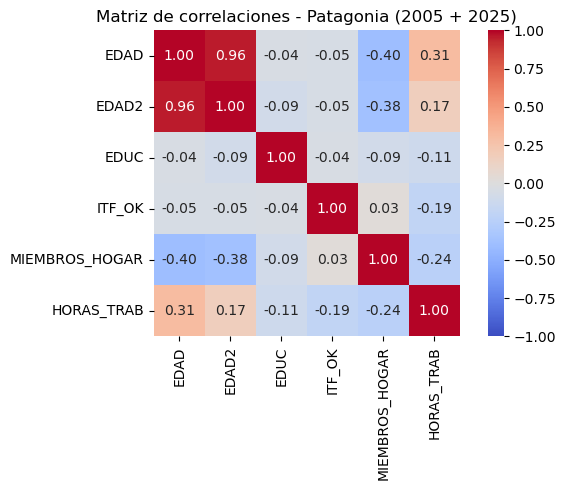

In [8]:
# === TP2 - PARTE 2 (Correlaciones rápidas) ====================================
import matplotlib.pyplot as plt
import seaborn as sns

base2 = pd.read_csv(csv_out)
base2.columns = base2.columns.str.upper().str.strip()

vars_corr = ["EDAD","EDAD2","EDUC","ITF_OK","MIEMBROS_HOGAR","HORAS_TRAB"]
print("NaNs por variable usada:", base2[vars_corr].isna().sum().to_dict())

corr = base2[vars_corr].corr(numeric_only=True).round(2)
display(corr)

plt.figure(figsize=(7,5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, square=True)
plt.title("Matriz de correlaciones - Patagonia (2005 + 2025)")
plt.tight_layout()
plt.show()

In [10]:
# === TP2 — Instalación de librerías necesarias (solo correr una vez) ===
import sys
import subprocess

def install_package(package):
    """Instala un paquete usando pip si no está instalado."""
    try:
        __import__(package)
        print(f"✅ {package} ya está instalado.")
    except ImportError:
        print(f"📦 Instalando {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", package])
        print(f"✅ {package} instalado correctamente.\n")

# Lista de paquetes necesarios para PCA y Clustering
packages = [
    "pandas",
    "numpy",
    "matplotlib",
    "seaborn",
    "scikit-learn",
    "scipy",
    "statsmodels"
]

for pkg in packages:
    install_package(pkg)

print("\n🚀 Instalación completa.")


✅ pandas ya está instalado.
✅ numpy ya está instalado.
✅ matplotlib ya está instalado.
✅ seaborn ya está instalado.
📦 Instalando scikit-learn...
✅ scikit-learn instalado correctamente.

✅ scipy ya está instalado.
✅ statsmodels ya está instalado.

🚀 Instalación completa.


In [11]:
# === TP2 — Carga de base limpia y selección de variables para análisis ===
import pandas as pd
import numpy as np

# Ruta a tu base limpia del TP2
path_base = r"C:\Users\gasto\Desktop\Taller de Programación\TP2\base_tp2_limpia_indiv.csv"

base = pd.read_csv(path_base)
base.columns = base.columns.str.upper().str.strip()

# Variables que vamos a usar en PCA/Clustering
vars_pca = ["EDAD", "EDAD2", "EDUC", "ITF_OK", "MIEMBROS_HOGAR", "HORAS_TRAB"]

# Filtrar filas completas para estas variables
X = base[vars_pca].copy()
X = X.replace([np.inf, -np.inf], np.nan).dropna()

print("📊 Observaciones usadas para PCA/Clustering:", X.shape)
display(X.head())

📊 Observaciones usadas para PCA/Clustering: (2323, 6)


,EDAD,EDAD2,EDUC,ITF_OK,MIEMBROS_HOGAR,HORAS_TRAB
3229,48.0,2304.0,6.0,1,3.0,35.0
3232,39.0,1521.0,3.0,1,1.0,48.0
3233,36.0,1296.0,4.0,1,1.0,45.0
3234,30.0,900.0,4.0,1,1.0,48.0
3235,54.0,2916.0,4.0,1,1.0,0.0


In [12]:
# === TP2 — Escalado (StandardScaler) ===
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=True, with_std=True)
X_scaled = scaler.fit_transform(X)

print("✅ Escalado listo. Media aprox.:", np.round(X_scaled.mean(axis=0), 4))
print("Desvíos ≈ 1:", np.round(X_scaled.std(axis=0), 4))

✅ Escalado listo. Media aprox.: [ 0.  0. -0.  0. -0.  0.]
Desvíos ≈ 1: [1. 1. 1. 1. 1. 1.]


In [13]:
# === TP2 — PCA: ajuste y resúmenes ===
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np

# Ajusto PCA sobre variables estandarizadas
pca = PCA()                 # sin n_components: calcula todos (6 en tu caso)
scores = pca.fit_transform(X_scaled)   # “scores” (PCs de cada persona)

# % de varianza explicada por componente
evr = pca.explained_variance_ratio_
evr_cum = evr.cumsum()

print("Varianza explicada:", np.round(evr, 4))
print("Acumulada:", np.round(evr_cum, 4))

# Loadings (ponderadores de cada variable en cada PC)
loadings = pd.DataFrame(
    pca.components_.T,
    index=X.columns,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)]
)
display(loadings.round(3))

# Guardamos también el dataframe de scores con el índice original
pcs = pd.DataFrame(scores, index=X.index, columns=[f"PC{i+1}" for i in range(pca.n_components_)])
# Para traer ANIO y otras etiquetas para gráficos:
meta = base.loc[X.index, ["ANIO"]].copy()


Varianza explicada: [0.3415 0.1991 0.1739 0.1631 0.1201 0.0023]
Acumulada: [0.3415 0.5406 0.7145 0.8776 0.9977 1.    ]


,PC1,PC2,PC3,PC4,PC5,PC6
EDAD,0.688,-0.041,-0.051,-0.033,0.152,-0.706
EDAD2,0.690,-0.048,-0.043,-0.039,0.129,0.708
EDUC,-0.110,0.660,-0.420,0.015,0.613,0.015
ITF_OK,0.003,0.203,0.889,0.140,0.387,0.003
MIEMBROS_HOGAR,-0.183,-0.560,-0.027,-0.577,0.565,0.004
HORAS_TRAB,-0.068,-0.454,-0.171,0.803,0.340,0.007


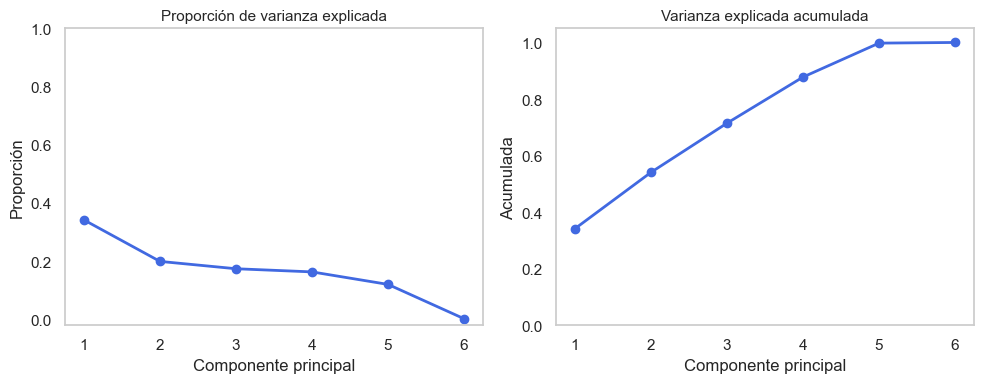

In [17]:
# === TP2 – PCA: Scree plots ===
import matplotlib.pyplot as plt
import numpy as np

ticks = np.arange(1, len(evr) + 1)

plt.figure(figsize=(10, 4))

# --- Panel 1: Proporción de varianza explicada ---
plt.subplot(1, 2, 1)
plt.plot(ticks, evr, marker='o', color='royalblue', linewidth=2)
plt.title("Proporción de varianza explicada", fontsize=11)
plt.xlabel("Componente principal")
plt.ylabel("Proporción")
plt.xticks(ticks)
plt.ylim(-0.02, 1)  # 🔧 margen inferior agregado
plt.grid(False)
plt.tick_params(axis='both', which='both', direction='out')

# --- Panel 2: Varianza explicada acumulada ---
plt.subplot(1, 2, 2)
plt.plot(ticks, evr_cum, marker='o', color='royalblue', linewidth=2)
plt.title("Varianza explicada acumulada", fontsize=11)
plt.xlabel("Componente principal")
plt.ylabel("Acumulada")
plt.xticks(ticks)
plt.ylim(0, 1.05)  # margen superior leve
plt.grid(False)
plt.tick_params(axis='both', which='both', direction='out')

plt.tight_layout()
plt.show()

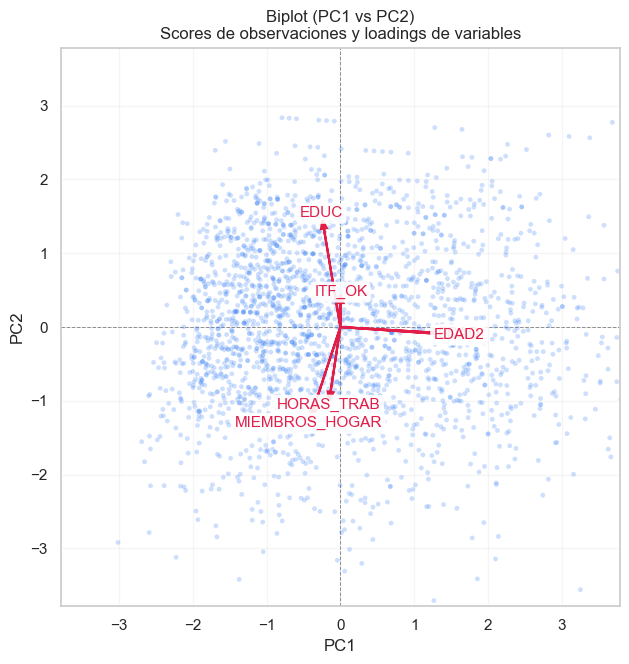

In [21]:
# === TP2 – PCA: BIPLOT (PC1 vs PC2) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# (1) Reconstruyo scores y loadings de forma segura
#    - pcs_df: DataFrame con columnas PC1, PC2, ...
#    - load_df: DataFrame con columnas PC1, PC2, ...
pcs_raw = pca.transform(X_scaled)                       
pcs_df  = (pd.DataFrame(pcs_raw, columns=[f"PC{i+1}" for i in range(pca.n_components_)])
           if not isinstance(pcs_raw, pd.DataFrame)
           else pcs_raw)

load_df = pd.DataFrame(
    pca.components_.T, index=X.columns,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)]
)

# (2) Tomo PC1 y PC2 como vectores numpy 
x_scores = pcs_df.iloc[:, 0].to_numpy()   # PC1
y_scores = pcs_df.iloc[:, 1].to_numpy()   # PC2

# (3) Parámetros de estética
point_color   = "#3b82f6"   # azul
arrow_color   = "#e11d48"   # rojo
point_alpha   = 0.25
point_size    = 12
arrow_scale   = 2.2
label_fontsz  = 11
title_fontsz  = 12

# (4) Figura
fig, ax = plt.subplots(1, 1, figsize=(6.8, 6.8))

# Puntos (scores)
ax.scatter(x_scores, y_scores, s=point_size, color=point_color,
           alpha=point_alpha, edgecolors="none", zorder=1)

# Ejes en 0
ax.axhline(0, color="gray", ls="--", lw=0.7, zorder=0)
ax.axvline(0, color="gray", ls="--", lw=0.7, zorder=0)

# Límites simétricos
lim = np.percentile(np.abs(np.column_stack([x_scores, y_scores])), 99) * 1.1
lim = max(lim, 1.2)
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)

# Flechas (loadings) y etiquetas
for var, row in load_df.iterrows():
    x = row["PC1"] * arrow_scale
    y = row["PC2"] * arrow_scale
    ax.arrow(0, 0, x, y, color=arrow_color, lw=1.6, length_includes_head=True,
             head_width=0.08*arrow_scale/2.2, head_length=0.12*arrow_scale/2.2, zorder=3)
    ax.text(x*1.06, y*1.06, var, fontsize=label_fontsz, color=arrow_color,
            ha="center", va="center",
            bbox=dict(boxstyle="round,pad=0.22", fc="white", ec="none", alpha=0.9),
            zorder=4)

# Aspecto y rótulos
ax.set_aspect('equal', adjustable='box')   # evita la advertencia y mantiene 1:1
ax.grid(True, alpha=0.18)
ax.set_xlabel("PC1"); ax.set_ylabel("PC2")
ax.set_title("Biplot (PC1 vs PC2)\nScores de observaciones y loadings de variables",
             fontsize=title_fontsz)

plt.tight_layout()
plt.show()


In [22]:
# === TP2 – CLUSTERING (K-MEANS) – Instalación y librerías ===
import sys, importlib, subprocess

# Verifica e instala librerías necesarias
def ensure(pkg):
    try:
        importlib.import_module(pkg)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", pkg])

for p in ["pandas", "numpy", "matplotlib", "seaborn", "scikit-learn"]:
    ensure(p)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [24]:
# === Preparación de datos (reutilizamos base del PCA) ===

# Variables a usar (las mismas del PCA)
vars_pca = ["EDAD", "EDAD2", "EDUC", "ITF_OK", "MIEMBROS_HOGAR", "HORAS_TRAB"]
X = base[vars_pca].dropna()

# Estandarizar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar PCA (2 componentes para clusterizar)
pca = PCA(n_components=2)
pcs = pca.fit_transform(X_scaled)

# DataFrame con los componentes
df_pca = pd.DataFrame(pcs, columns=["PC1", "PC2"])
df_pca.head()

,PC1,PC2
0,0.543775,1.066122
1,-0.022522,-0.004747
2,-0.406284,0.599621
3,-1.007165,0.557159
4,1.816814,1.669746


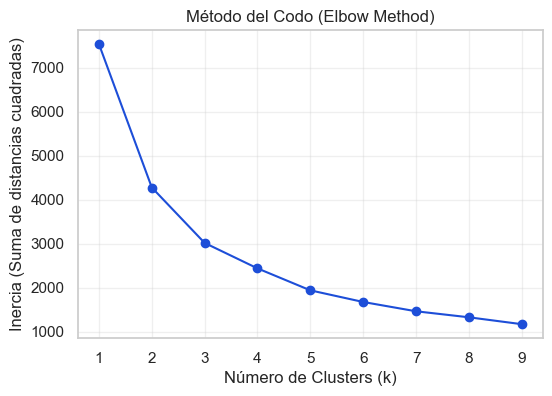

In [25]:
# === Método del Codo para elegir k ===
inertia = []
K = range(1, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_pca)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(K, inertia, 'o-', color="#1d4ed8")
plt.title("Método del Codo (Elbow Method)")
plt.xlabel("Número de Clusters (k)")
plt.ylabel("Inercia (Suma de distancias cuadradas)")
plt.grid(True, alpha=0.3)
plt.show()

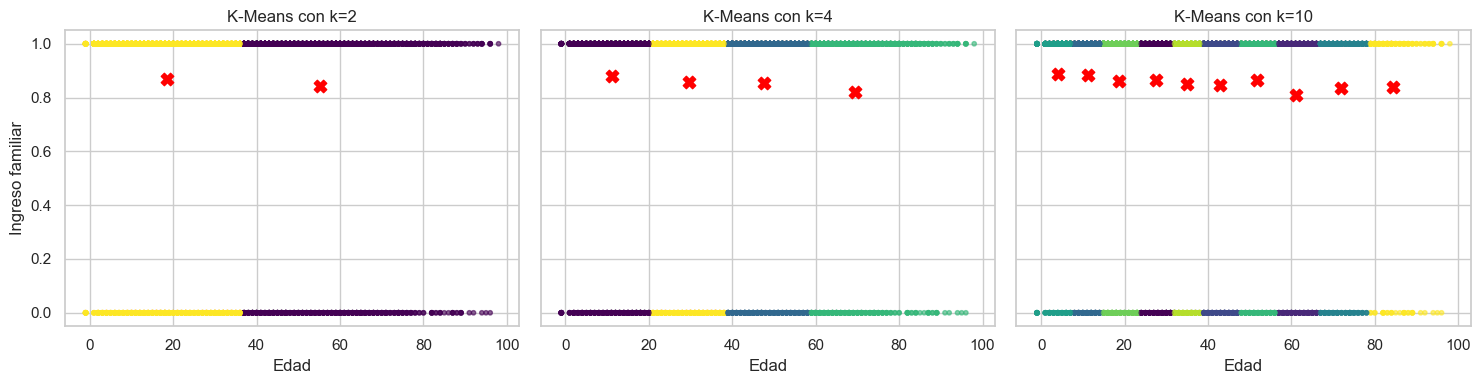

In [28]:
# === K-Means sobre variables originales: edad e ingreso ===
from sklearn.cluster import KMeans

X2 = base[["EDAD", "ITF_OK"]].dropna()

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)  # 🔹 sharey=True evita repetir “Ingreso familiar”

for i, k in enumerate([2, 4, 10]):
    kmeans = KMeans(n_clusters=k, n_init=20, random_state=42)
    labels = kmeans.fit_predict(X2)
    axes[i].scatter(X2["EDAD"], X2["ITF_OK"], c=labels, cmap="viridis", s=10, alpha=0.6)
    axes[i].scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1],
                    c="red", marker="X", s=80)
    axes[i].set_title(f"K-Means con k={k}")
    axes[i].set_xlabel("Edad")
    if i == 0:
        axes[i].set_ylabel("Ingreso familiar")  # solo en el primer gráfico

plt.tight_layout()
plt.show()


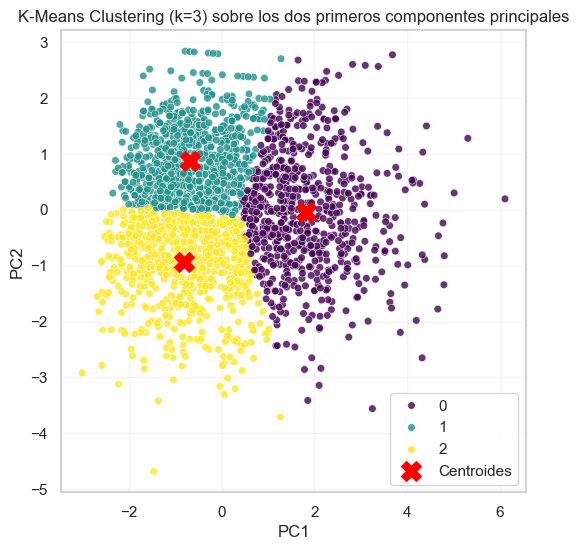

In [26]:
# ADICIONAL === Aplicamos K-Means con el k óptimo ===
k_opt = 3  # Ajustá según el gráfico del codo

kmeans = KMeans(n_clusters=k_opt, random_state=42)
clusters = kmeans.fit_predict(df_pca)
df_pca["Cluster"] = clusters

# === Visualización ===
plt.figure(figsize=(6, 6))
sns.scatterplot(
    data=df_pca, x="PC1", y="PC2", hue="Cluster",
    palette="viridis", s=30, alpha=0.8
)
plt.scatter(
    kmeans.cluster_centers_[:, 0],
    kmeans.cluster_centers_[:, 1],
    s=200, c="red", marker="X", label="Centroides"
)
plt.title(f"K-Means Clustering (k={k_opt}) sobre los dos primeros componentes principales")
plt.legend()
plt.grid(alpha=0.2)
plt.show()

In [2]:
# Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# === Cargar la base limpia del TP2 ===
base = pd.read_csv(r"C:\Users\gasto\Desktop\Taller de Programación\TP2\base_tp2_limpia_indiv.csv")

# Limpieza básica
base.columns = base.columns.str.upper().str.strip()

# Verificamos que esté bien
print("Observaciones totales:", base.shape)
base.head()

Observaciones totales: (8588, 19)


,CODUSU,NRO_HOGAR,ANIO,TRIMESTRE,REGION,CH04,CH06,CH07,CH08,NIVEL_ED,ESTADO,CAT_INAC,IPCF,MIEMBROS_HOGAR,EDAD,EDAD2,EDUC,ITF_OK,HORAS_TRAB
0,125814,1.0,2005,1,Patagónica,Varón,46.0,Casado,Obra social (incluye PAMI),Secundaria Incompleta,Ocupado,0.0,480.0,5.0,46.0,2116.0,NaN,1,48.0
1,125814,1.0,2005,1,Patagónica,Mujer,32.0,Casado,Obra social (incluye PAMI),Secundaria Incompleta,Inactivo,Ama de casa,480.0,5.0,32.0,1024.0,NaN,1,0.0
2,125814,1.0,2005,1,Patagónica,Varón,14.0,Soltero,Obra social (incluye PAMI),Primaria Completa,Inactivo,Estudiante,480.0,5.0,14.0,196.0,NaN,1,0.0
3,125814,1.0,2005,1,Patagónica,Varón,9.0,Soltero,Obra social (incluye PAMI),Primaria Incompleta (incluye educación especial),Menor de 10 años,Estudiante,480.0,5.0,9.0,81.0,NaN,1,0.0
4,125814,1.0,2005,1,Patagónica,Mujer,3.0,Soltero,Obra social (incluye PAMI),Sin instrucción,Menor de 10 años,Menor de 6 años,480.0,5.0,3.0,9.0,NaN,1,0.0


In [3]:
# === Clustering jerárquico: preparar datos ===
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# mismas variables que PCA
vars_hc = ["EDAD", "EDAD2", "EDUC", "ITF_OK", "MIEMBROS_HOGAR", "HORAS_TRAB"]

X_hc = base[vars_hc].dropna().copy()

scaler_hc = StandardScaler()
X_hc_scaled = scaler_hc.fit_transform(X_hc)

print("Observaciones usadas (HC):", X_hc.shape)

Observaciones usadas (HC): (2323, 6)


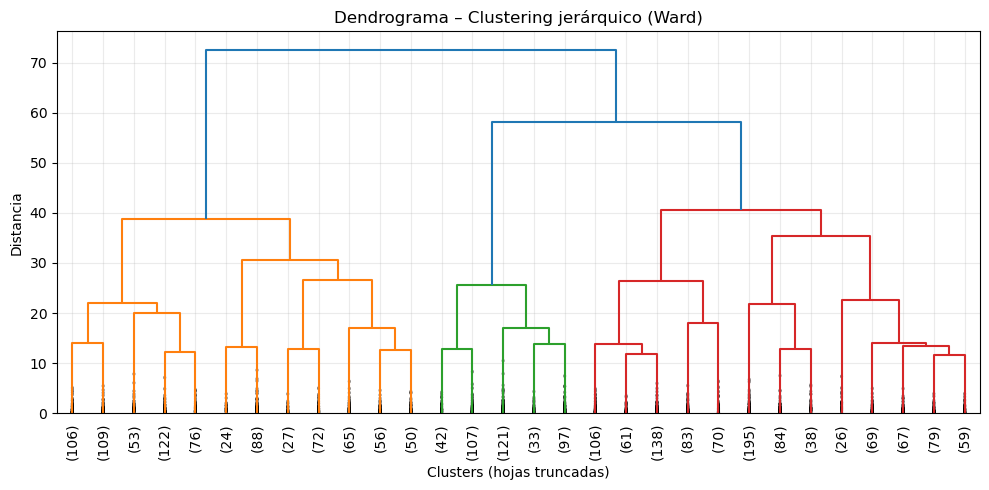

In [4]:
# === Dendrograma (Ward) ===
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(X_hc_scaled, method="ward")  # distancia euclídea + criterio Ward

plt.figure(figsize=(10, 5))
dendrogram(
    Z,
    truncate_mode="lastp",   # muestra sólo los últimos clusters
    p=30,                    # cantidad de hojas/cluster que se ven
    leaf_rotation=90,
    leaf_font_size=10,
    show_contracted=True
)
plt.title("Dendrograma – Clustering jerárquico (Ward)")
plt.xlabel("Clusters (hojas truncadas)")
plt.ylabel("Distancia")
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()

In [20]:
import sys
print(sys.executable)

C:\ProgramData\anaconda3\python.exe


In [21]:
!C:\ProgramData\anaconda3\python.exe -m pip install kmodes

Defaulting to user installation because normal site-packages is not writeable


In [24]:
import sys, site, pprint
print("Python:", sys.version)
print("Executable:", sys.executable)
print("\nUser site-packages:")
print(site.getusersitepackages())
print("\nsys.path (primeras 5):")
pprint.pprint(sys.path[:5])

Python: 3.13.5 | packaged by Anaconda, Inc. | (main, Jun 12 2025, 16:37:03) [MSC v.1929 64 bit (AMD64)]
Executable: C:\ProgramData\anaconda3\python.exe

User site-packages:
C:\Users\gasto\AppData\Roaming\Python\Python313\site-packages

sys.path (primeras 5):
['C:\\ProgramData\\anaconda3\\python313.zip',
 'C:\\ProgramData\\anaconda3\\DLLs',
 'C:\\ProgramData\\anaconda3\\Lib',
 'C:\\ProgramData\\anaconda3',
 '']


In [25]:
import sys

# Agregamos explícitamente la ruta donde pip instaló kmodes
user_site = r"C:\Users\gasto\AppData\Roaming\Python\Python313\site-packages"
if user_site not in sys.path:
    sys.path.append(user_site)

# IMPORT CORRECTO (con mayúsculas)
from kmodes.kmodes import KModes
print("✅ KModes importado correctamente")

✅ KModes importado correctamente


In [27]:
# K0 - Instalar e importar kmodes en ESTE entorno
import sys, subprocess, importlib

def ensure(pkg, mod=None):
    mod = mod or pkg
    try:
        importlib.import_module(mod)
        print(f"OK: {pkg} ya está instalado.")
    except ImportError:
        print(f"Instalando {pkg} ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])
        importlib.import_module(mod)
        print(f"OK: {pkg} instalado.")

ensure("kmodes", "kmodes")
ensure("seaborn", "seaborn")

from kmodes.kmodes import KModes
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

OK: kmodes ya está instalado.
OK: seaborn ya está instalado.


In [30]:
# === TP2 – K-MODA: preparación de base categórica ===
base.columns = base.columns.str.upper().str.strip()

# Detectar variable de pobreza para excluir
col_pobre = "POBRE_OK" if "POBRE_OK" in base.columns else ("POBRE" if "POBRE" in base.columns else None)

# Seleccionar columnas categóricas de baja cardinalidad
candidatas = []
for c in base.columns:
    if base[c].dropna().nunique() <= 10 and c not in ["ITF_OK", "EDAD2"] and (col_pobre is None or c != col_pobre):
        candidatas.append(c)

X_kmoda = base[candidatas].dropna().copy()
for c in X_kmoda.columns:
    X_kmoda[c] = X_kmoda[c].astype(str)

print("Variables incluidas:", len(X_kmoda.columns))
display(X_kmoda.head())

Variables incluidas: 8


,NRO_HOGAR,ANIO,TRIMESTRE,REGION,CH04,CH07,ESTADO,EDUC
3229,1.0,2025,1,44,2,3,1,6.0
3230,1.0,2025,1,44,1,5,3,3.0
3231,1.0,2025,1,44,1,5,4,1.0
3232,1.0,2025,1,44,1,5,1,3.0
3233,2.0,2025,1,44,2,5,1,4.0


In [31]:
# === TP2 – K-MODA: ejecución con distintos k ===
from kmodes.kmodes import KModes

k_values = [2, 4, 10]
labels_kmodes = {}

for k in k_values:
    km = KModes(n_clusters=k, init="Huang", n_init=10, random_state=42)
    clusters = km.fit_predict(X_kmoda)
    labels_kmodes[k] = pd.Series(clusters, index=X_kmoda.index, name=f"KM_k{k}")
    print(f"\n--- k = {k} ---")
    print(pd.Series(clusters).value_counts().sort_index())

print("\n✅ Clustering K-Modes completado.")


--- k = 2 ---
0    3212
1    2147
Name: count, dtype: int64

--- k = 4 ---
0    2014
1    1420
2     972
3     953
Name: count, dtype: int64

--- k = 10 ---
0    618
1    740
2    777
3    695
4    791
5    245
6    550
7     45
8    641
9    257
Name: count, dtype: int64

✅ Clustering K-Modes completado.


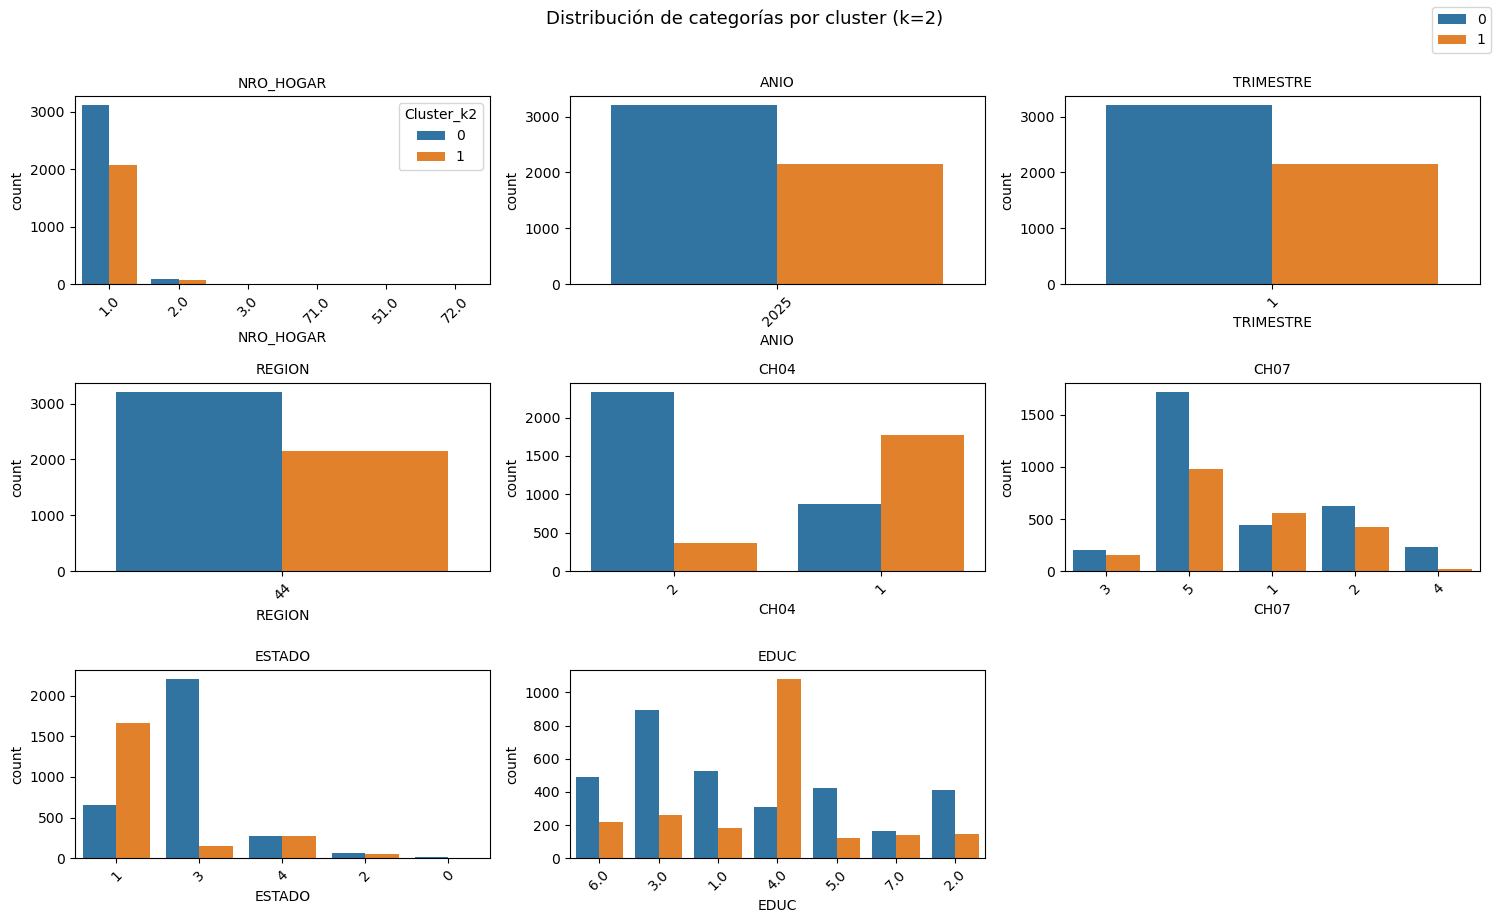

In [33]:
# === TP2 – K-MODA: visualización mejorada (k=2) ===
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df_vis = X_kmoda.copy()
df_vis["Cluster_k2"] = labels_kmodes[2]

n_cols = 3
n_vars = len(df_vis.columns) - 1  # excluye la columna del cluster
n_rows = int(np.ceil(n_vars / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 3))
axes = axes.flatten()

for i, c in enumerate(df_vis.columns[:-1]):
    sns.countplot(x=df_vis[c], hue=df_vis["Cluster_k2"], ax=axes[i], palette="tab10")
    axes[i].set_title(c, fontsize=10)
    axes[i].tick_params(axis="x", rotation=45)
    axes[i].legend_.remove() if i != 0 else None  # mantener una sola leyenda

# Oculta los ejes vacíos si sobran
for j in range(n_vars, len(axes)):
    axes[j].set_visible(False)

fig.suptitle("Distribución de categorías por cluster (k=2)", fontsize=13, y=1.02)
fig.legend(*axes[0].get_legend_handles_labels(), loc="upper right")
plt.tight_layout()
plt.show()


=== Visualización K-Modes con k=4 ===


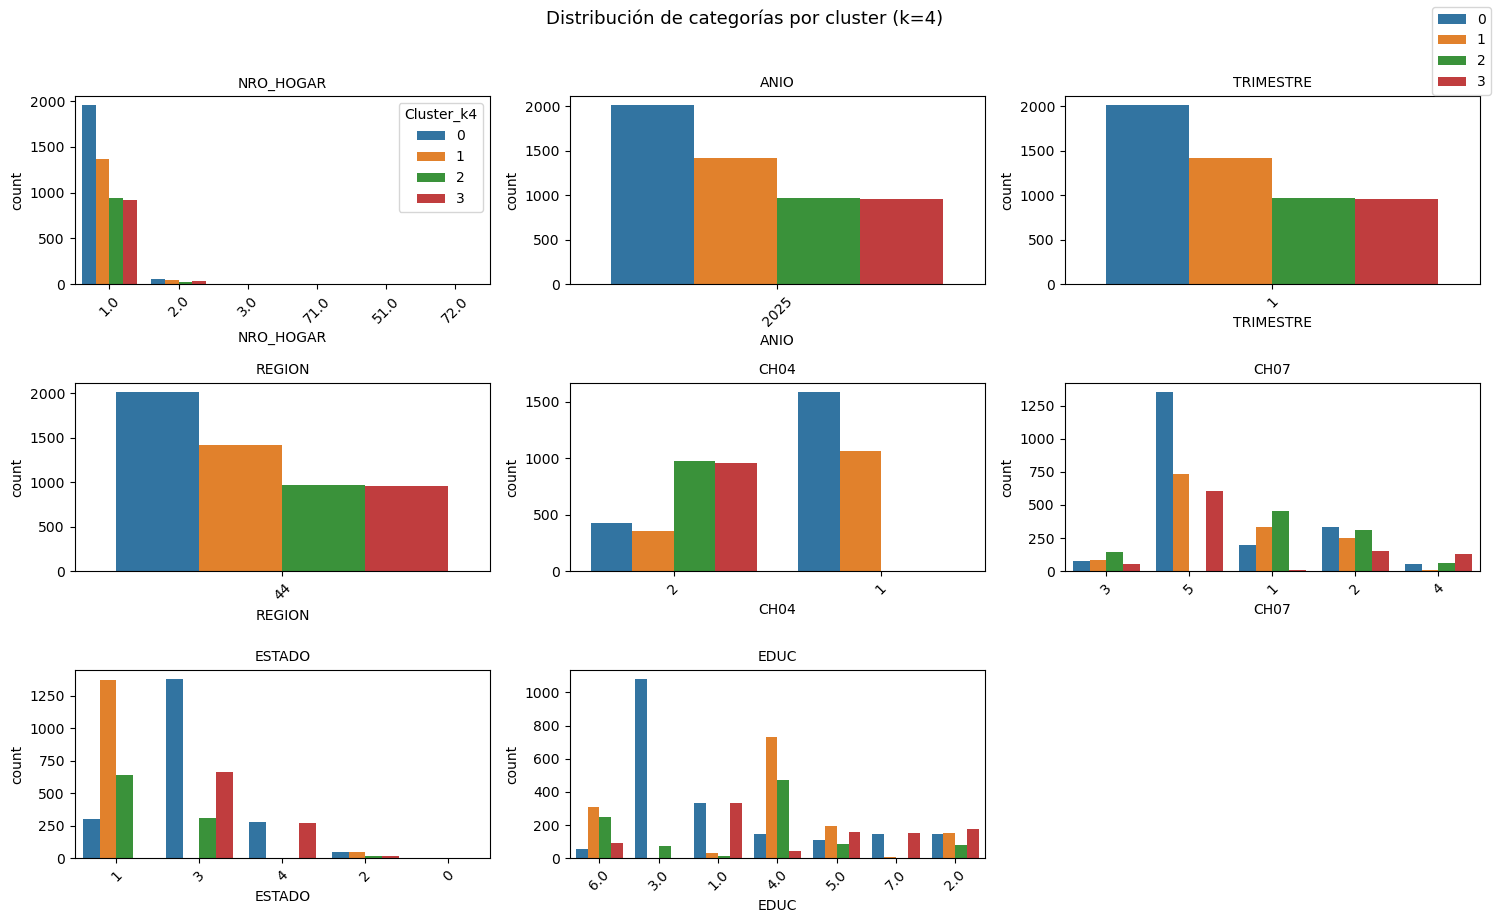


=== Visualización K-Modes con k=10 ===


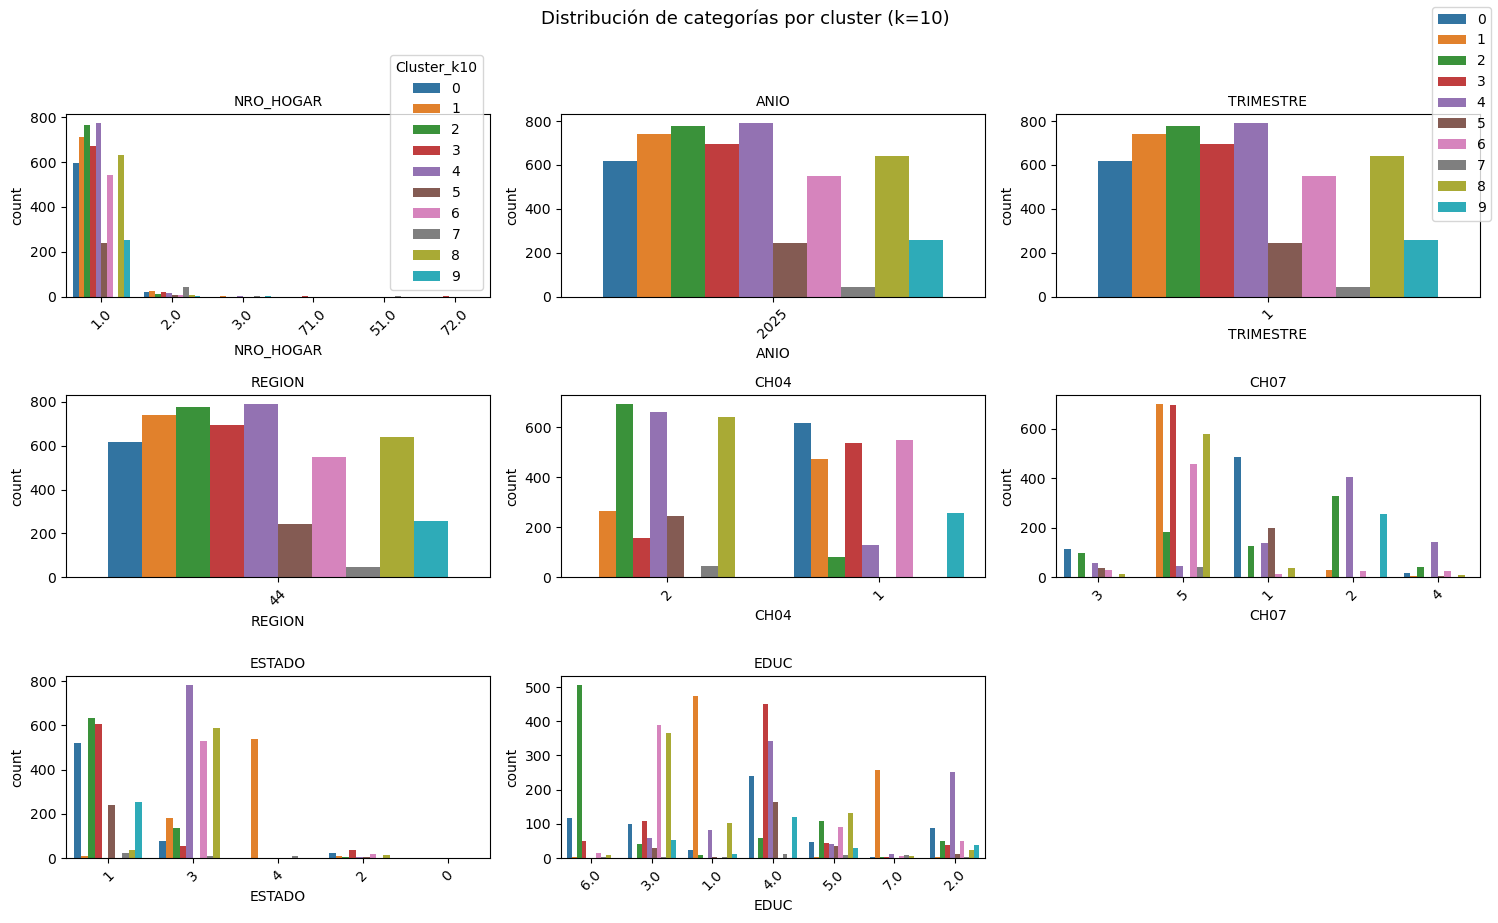

In [35]:
# === TP2 – K-MODA: visualización múltiple (k=4 y k=10) ===
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

for k in [4, 10]:
    print(f"\n=== Visualización K-Modes con k={k} ===")

    df_vis = X_kmoda.copy()
    df_vis[f"Cluster_k{k}"] = labels_kmodes[k]

    n_cols = 3
    n_vars = len(df_vis.columns) - 1
    n_rows = int(np.ceil(n_vars / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 3))
    axes = axes.flatten()

    for i, c in enumerate(df_vis.columns[:-1]):
        sns.countplot(x=df_vis[c], hue=df_vis[f"Cluster_k{k}"], ax=axes[i], palette="tab10")
        axes[i].set_title(f"{c}", fontsize=10)
        axes[i].tick_params(axis="x", rotation=45)
        axes[i].legend_.remove() if i != 0 else None

    # Ocultar ejes vacíos
    for j in range(n_vars, len(axes)):
        axes[j].set_visible(False)

    fig.suptitle(f"Distribución de categorías por cluster (k={k})", fontsize=13, y=1.02)
    fig.legend(*axes[0].get_legend_handles_labels(), loc="upper right")
    plt.tight_layout()
    plt.show()

In [36]:
fig.savefig(r"C:\Users\gasto\Desktop\kmoda_k4y10.png", dpi=300, bbox_inches="tight")